In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-04-23 10:34:52.084587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dfbc
dfbc = pd.read_csv('bitcoin_historical_data.csv')
dfbc.drop_duplicates(inplace=True)
dfbc['Date'] = pd.to_datetime(dfbc['Date'], format='%m/%d/%Y')

In [3]:
# Clean dfbc
def clean_numeric(value):
    if isinstance(value, str):
        value = value.replace(',', '')
        if 'K' in value:
            value = float(value.replace('K', '')) * 1000
        return pd.to_numeric(value, errors='coerce')
    return value

dfbc['Price'] = dfbc['Price'].apply(clean_numeric)
dfbc['Vol.'] = dfbc['Vol.'].apply(clean_numeric)
dfbc['Change %'] = dfbc['Change %'].str.rstrip('%').astype(float)
dfbc_newset = dfbc[['Date', 'Price', 'Vol.', 'Change %']]

In [4]:
# JSON files
json_files = [
    'av_transactions_per_block.json',
    'estimated_transaction_volume_usd.json',
    'fees_per-_transaction.json',
    'market_value_to_realised_value.json',
    'transactions_total.json'
]
key_map = {
    'av_transactions_per_block.json': 'n-transactions-per-block',
    'estimated_transaction_volume_usd.json': 'estimated-transaction-volume-usd',
    'fees_per-_transaction.json': 'fees-usd-per-transaction',
    'market_value_to_realised_value.json': 'mvrv',
    'transactions_total.json': 'n-transactions-total'
}
names = {
    'n-transactions-per-block': 'Transactions Per Block',
    'estimated-transaction-volume-usd': 'Estimated Transaction Volume',
    'fees-usd-per-transaction': 'Fees Per Transaction',
    'mvrv': 'Market Value to Realised Value',
    'n-transactions-total': 'Confirmed Payments'
}


In [5]:
#Process these nasty JSONs
dfs = {}
for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
    key = key_map[json_file]
    if key not in data:
        print(f"Error: Key {key} not in {json_file}")
        continue
    df = pd.DataFrame(data[key])
    if 'y' not in df or df['y'].isna().all():
        print(f"Error: No valid data in {json_file}")
        continue
    df['Date'] = pd.to_datetime(df['x'], unit='ms').dt.floor('D')
    df[names[key]] = pd.to_numeric(df['y'], errors='coerce')
    if df[names[key]].isna().sum() > 0:
        print(f"Warning: {json_file} has {df[names[key]].isna().sum()} NaNs in raw data")
    df = df[['Date', names[key]]].drop_duplicates(subset=['Date'])
    df = df.sort_values('Date').set_index('Date').resample('D').interpolate(method='linear').bfill().reset_index()  # Updated
    if df[names[key]].isna().sum() > 0:
        print(f"Warning: {json_file} has {df[names[key]].isna().sum()} NaNs after interpolation")
    dfs[json_file] = df
    print(f"{json_file}: {df['Date'].min()} to {df['Date'].max()}, {len(df)} rows")

av_transactions_per_block.json: 2009-01-17 00:00:00 to 2025-04-03 00:00:00, 5921 rows
estimated_transaction_volume_usd.json: 2010-08-28 00:00:00 to 2025-04-04 00:00:00, 5334 rows
fees_per-_transaction.json: 2009-01-17 00:00:00 to 2025-04-03 00:00:00, 5921 rows
market_value_to_realised_value.json: 2010-10-09 00:00:00 to 2025-04-04 00:00:00, 5292 rows
transactions_total.json: 2009-01-03 00:00:00 to 2025-04-02 00:00:00, 5934 rows


In [6]:
#MVRV is getting on my nerves
mvrv_df = dfs['market_value_to_realised_value.json']
print("\nMVRV processed sample:")
print(mvrv_df.head(10))
print(mvrv_df.tail(10))
print(f"MVRV NaNs: {mvrv_df['Market Value to Realised Value'].isna().sum()}")


MVRV processed sample:
        Date  Market Value to Realised Value
0 2010-10-09                        6.352667
1 2010-10-10                        6.352784
2 2010-10-11                        6.352902
3 2010-10-12                        6.353020
4 2010-10-13                        6.353138
5 2010-10-14                        5.997097
6 2010-10-15                        5.641057
7 2010-10-16                        5.396010
8 2010-10-17                        5.150964
9 2010-10-18                        4.959554
           Date  Market Value to Realised Value
5282 2025-03-26                        1.991501
5283 2025-03-27                        1.991270
5284 2025-03-28                        1.991040
5285 2025-03-29                        1.956574
5286 2025-03-30                        1.922109
5287 2025-03-31                        1.887643
5288 2025-04-01                        1.887052
5289 2025-04-02                        1.886462
5290 2025-04-03                        1.885871
5

In [7]:
# Add dfbc
dfs['dfbc'] = dfbc_newset
print(f"dfbc: {dfbc_newset['Date'].min()} to {dfbc_newset['Date'].max()}, {len(dfbc_newset)} rows")

dfbc: 2010-07-18 00:00:00 to 2024-03-24 00:00:00, 4999 rows


In [8]:
#Make like siamnese twins and merge
dffin = dfs['av_transactions_per_block.json'].copy()
for json_file in json_files[1:]:
    right = dfs[json_file]
    dffin = pd.merge(dffin, right, on='Date', how='inner', suffixes=('', f'_{json_file}'))
    if any(col.endswith(f'_{json_file}') for col in dffin.columns):
        print(f"Warning: Duplicate columns after merging {json_file}: {[col for col in dffin.columns if col.endswith(f'_{json_file}')]}")
dffin = pd.merge(dffin, dfs['dfbc'], on='Date', how='inner')
dffin = dffin[dffin['Date'] >= '2010-10-09']
dffin = dffin[dffin['Date'] <= '2024-03-24']
columns = ['Date', 'Transactions Per Block', 'Estimated Transaction Volume', 
           'Fees Per Transaction', 'Market Value to Realised Value', 
           'Confirmed Payments', 'Price', 'Vol.', 'Change %']
dffin = dffin[columns]
dffin['Vol.'] = dffin['Vol.'].fillna(0)

In [9]:
# Verify dffin
print("\nInspecting dffin:")
print(dffin.head())
print(dffin.tail())
print(dffin.shape)
print("NaNs per column:\n", dffin.isna().sum())
print("Market Value to Realised Value stats:\n", dffin['Market Value to Realised Value'].describe())


Inspecting dffin:
        Date  Transactions Per Block  Estimated Transaction Volume  \
0 2010-10-09                2.137972                   4297.880700   
1 2010-10-10                2.144458                   3621.558750   
2 2010-10-11                2.150943                   2945.236800   
3 2010-10-12                2.076484                   3295.342325   
4 2010-10-13                2.002025                   3645.447850   

   Fees Per Transaction  Market Value to Realised Value  Confirmed Payments  \
0          1.901163e-10                        6.352667            126453.0   
1          2.851744e-10                        6.352784            126831.0   
2          3.802326e-10                        6.352902            127185.5   
3          2.851744e-10                        6.353020            127540.0   
4          1.901163e-10                        6.353138            127894.5   

   Price      Vol.  Change %  
0    0.1  187850.0       0.0  
1    0.1   50680.0     

In [10]:
# Normalize
features = dffin.drop('Date', axis=1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['Date'] = dffin['Date'].values
print("\nScaled data:")
print(scaled_df.head())
print(scaled_df.tail())
print(scaled_df.shape)
scaled_df.to_csv('dffin_scaled.csv', index=False)


Scaled data:
   Transactions Per Block  Estimated Transaction Volume  Fees Per Transaction  \
0                0.000102                  1.104717e-07          3.176098e-12   
1                0.000104                  7.596327e-08          4.764147e-12   
2                0.000105                  4.145487e-08          6.352196e-12   
3                0.000088                  5.931853e-08          4.764147e-12   
4                0.000071                  7.718218e-08          3.176098e-12   

   Market Value to Realised Value  Confirmed Payments  Price      Vol.  \
0                        0.829143        0.000000e+00    0.0  0.187938   
1                        0.829159        3.858333e-07    0.0  0.050704   
2                        0.829176        7.476796e-07    0.0  0.014097   
3                        0.829192        1.109526e-06    0.0  0.025672   
4                        0.829209        1.471372e-06    0.0  0.047582   

   Change %       Date  
0  0.145185 2010-10-09  
1  0

In [11]:
scaled_df = pd.read_csv('dffin_scaled.csv') 

In [12]:
# make like a banana and split
train_end = int(0.8 * len(scaled_df))  
val_end = int(0.9 * len(scaled_df))   
train_df = scaled_df[:train_end]
val_df = scaled_df[train_end:val_end]
test_df = scaled_df[val_end:]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 3932, Val: 492, Test: 492


In [13]:
# Create sequences
def create_sequences(data, seq_length=30, target_col=5):  # 5 is Price
    X, y = [], []
    data = data.drop('Date', axis=1).values
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_col])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_df, seq_length)
X_val, y_val = create_sequences(val_df, seq_length)
X_test, y_test = create_sequences(test_df, seq_length)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (3902, 30, 8), y_train shape: (3902,)


In [14]:
# Build LSTM
model = Sequential([
    Input(shape=(seq_length, 8)), 
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-5,
    restore_best_weights=True
)

In [16]:
# Train choo choo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increased, early stopping will halt
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2491e-04 - val_loss: 0.0025
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4756e-04 - val_loss: 0.0023
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.7130e-04 - val_loss: 0.0020
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9438e-04 - val_loss: 0.0017
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4290e-04 - val_loss: 0.0067
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0770e-04 - val_loss: 0.0021
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6298e-04 - val_loss: 0.0019
Epoch 10/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5418e-04 - val_loss: 0.0024
Epoch 11/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9384e-04 - val_loss: 0

In [17]:
#lets see the damage
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1714e-04 
Test Loss: 0.0007955024484544992
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


In [18]:
# Inverse scale predictions
dffin = pd.read_csv('dffin_final.csv')

In [19]:
#price was giving trouble
def clean_numeric(value):
    if isinstance(value, str):
        value = value.replace(',', '')
        if 'K' in value:
            value = float(value.replace('K', '')) * 1000
        return pd.to_numeric(value, errors='coerce')
    return value

dffin['Price'] = dffin['Price'].apply(clean_numeric)
print("dffin Price sample after cleaning:")
print(dffin[['Date', 'Price']].head())
print("Price NaNs:", dffin['Price'].isna().sum())

dffin Price sample after cleaning:
         Date  Price
0  2010-10-09    0.1
1  2010-10-10    0.1
2  2010-10-11    0.1
3  2010-10-12    0.1
4  2010-10-13    0.1
Price NaNs: 0


In [20]:
# Fit scaler
scaler = MinMaxScaler()
scaler.fit(dffin[['Price']].dropna())  # Drop NaNs if any
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_unscaled = scaler.inverse_transform(predictions)
print("Sample predictions (unscaled):", predictions_unscaled[:5].flatten())
print("Sample actual (unscaled):", y_test_unscaled[:5].flatten())

Sample predictions (unscaled): [17537.105 17498.73  17450.947 17413.016 17348.732]
Sample actual (unscaled): [16441.3 16902.8 16831.8 16820.6 16779.1]


In [21]:
# pretending like i have money
initial_capital = 10000  # USD
capital = initial_capital
btc_held = 0
portfolio = [capital]
signals = ['Hold']  # First action is neutral
for i in range(1, len(predictions_unscaled)):
    current_price = y_test_unscaled[i-1][0]  # P_t
    predicted_price = predictions_unscaled[i][0]  # \hat{P}_{t+1}
    if predicted_price > current_price and capital > 0:  # Buy
        btc_held = capital / current_price
        capital = 0
        signals.append('Buy')
    elif predicted_price < current_price and btc_held > 0:  # Sell
        capital = btc_held * current_price
        btc_held = 0
        signals.append('Sell')
    else:
        signals.append('Hold')
    portfolio.append(capital + btc_held * y_test_unscaled[i][0])

In [22]:
# Buy-and-hold portfolio
buy_hold_portfolio = initial_capital * y_test_unscaled / y_test_unscaled[0][0]

In [23]:
# Calculate returns of holding 1BTC (for reference)
lstm_return = (portfolio[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (y_test_unscaled[-1][0] - y_test_unscaled[0][0]) / y_test_unscaled[0][0] * 100
print(f"LSTM Trading Return: {lstm_return:.2f}%")
print(f"Buy-and-Hold Return: {buy_hold_return:.2f}%")
print(f"Number of trades: {sum(1 for s in signals if s in ['Buy', 'Sell'])}")

LSTM Trading Return: 40.07%
Buy-and-Hold Return: 308.80%
Number of trades: 49


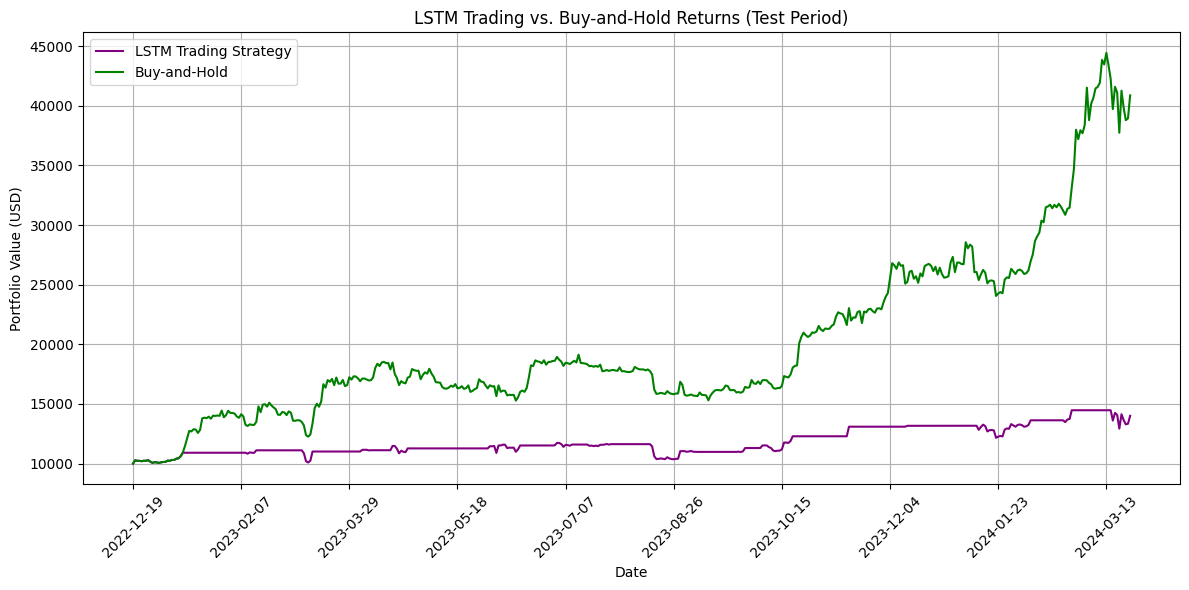

In [24]:
# Plot results: Prediction vs. Buy-and-Hold
dates = test_df['Date'].values[seq_length:]  # Align with y_test
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio, label='LSTM Trading Strategy', color='purple')
plt.plot(dates, buy_hold_portfolio, label='Buy-and-Hold', color='green')
plt.title('LSTM Trading vs. Buy-and-Hold Returns (Test Period)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.xticks(rotation=45, ticks=range(0, len(dates), 50), labels=dates[::50])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

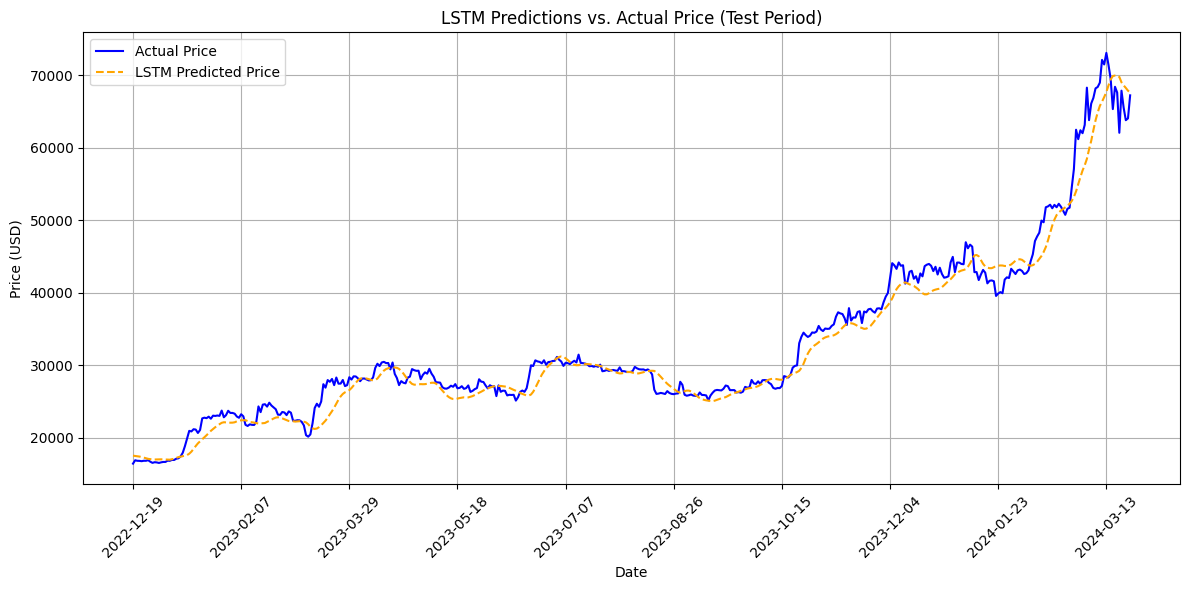

In [25]:
# Plot price predictions (for reference)
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_unscaled, label='Actual Price', color='blue')
plt.plot(dates, predictions_unscaled, label='LSTM Predicted Price', color='orange', linestyle='--')
plt.title('LSTM Predictions vs. Actual Price (Test Period)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45, ticks=range(0, len(dates), 50), labels=dates[::50])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

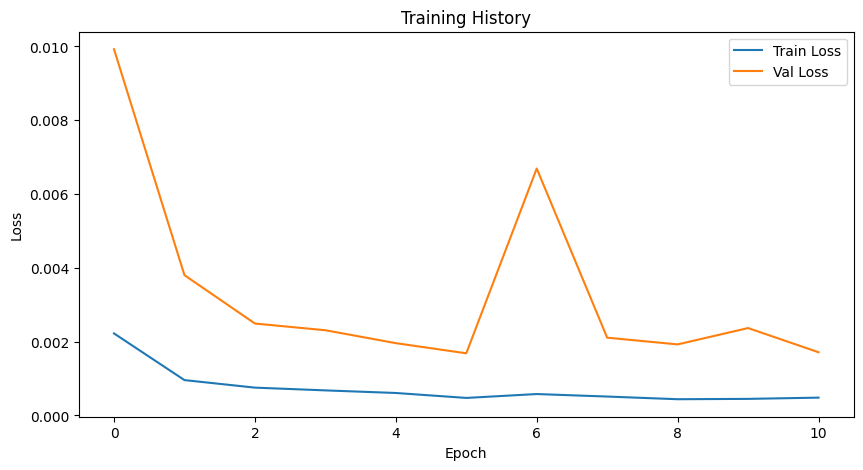

In [26]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()